In [1]:
# Sel 1: Impor library dan hubungkan Google Drive
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import shutil
import random
import zipfile
from google.colab import drive
import pickle
import matplotlib.pyplot as plt

# Set seed untuk reproduksibilitas
tf.random.set_seed(42)

# Hubungkan Google Drive
print("Menghubungkan Google Drive...")
drive.mount('/content/drive')

Menghubungkan Google Drive...
Mounted at /content/drive


In [2]:
# Sel 2: Verifikasi dan ekstrak dataset
zip_path = '/content/drive/MyDrive/RealWasteDataset/realwaste.zip'  # Sesuaikan path
extract_path = '/content/realwaste_data'

# Verifikasi keberadaan file zip
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"File zip tidak ditemukan di {zip_path}. Pastikan file realwaste.zip sudah diunggah ke Google Drive.")

# Ekstrak dataset
if not os.path.exists(extract_path):
    print(f"Mengekstrak dataset dari {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset diekstrak ke: {extract_path}")
else:
    print(f"Folder dataset sudah ada di: {extract_path}")

Mengekstrak dataset dari /content/drive/MyDrive/RealWasteDataset/realwaste.zip...
Dataset diekstrak ke: /content/realwaste_data


In [4]:
# Sel 3: Verifikasi struktur dataset dan jumlah citra per kelas
data_dir = os.path.join(extract_path, 'realwaste-main', 'RealWaste')  # Path yang diperbarui
classes = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash',
           'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
expected_counts = {
    'Cardboard': 461,
    'Food Organics': 411,
    'Glass': 420,
    'Metal': 790,
    'Miscellaneous Trash': 495,
    'Paper': 500,
    'Plastic': 921,
    'Textile Trash': 318,
    'Vegetation': 436
}

print("Memverifikasi struktur dataset...")
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Folder dataset tidak ditemukan di {data_dir}. Pastikan dataset diekstrak dengan benar.")

# Verifikasi keberadaan folder kelas dan jumlah citra
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    if not os.path.exists(class_path):
        raise FileNotFoundError(f"Folder kelas {cls} tidak ditemukan di {data_dir}.")
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    actual_count = len(images)
    expected_count = expected_counts[cls]
    if actual_count != expected_count:
        raise ValueError(f"Kelas {cls}: Jumlah citra ({actual_count}) tidak sesuai dengan yang diharapkan ({expected_count}).")
    print(f"Kelas {cls}: {actual_count} citra (sesuai)")

Memverifikasi struktur dataset...
Kelas Cardboard: 461 citra (sesuai)
Kelas Food Organics: 411 citra (sesuai)
Kelas Glass: 420 citra (sesuai)
Kelas Metal: 790 citra (sesuai)
Kelas Miscellaneous Trash: 495 citra (sesuai)
Kelas Paper: 500 citra (sesuai)
Kelas Plastic: 921 citra (sesuai)
Kelas Textile Trash: 318 citra (sesuai)
Kelas Vegetation: 436 citra (sesuai)


In [5]:
# Sel 4: Membagi dataset menjadi train dan validation
train_dir = os.path.join(extract_path, 'train')
val_dir = os.path.join(extract_path, 'validation')

# Buat direktori train dan validation
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Rasio pembagian: 80% train, 20% validation
train_ratio = 0.8
print("Membagi dataset: 80% train, 20% validation...")
for cls in classes:
    # Buat subfolder untuk train dan validation
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # Dapatkan daftar file di folder kelas
    class_path = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Acak urutan file
    random.shuffle(images)

    # Hitung jumlah data untuk train
    train_size = int(len(images) * train_ratio)

    # Bagi file ke train dan validation
    train_images = images[:train_size]
    val_images = images[train_size:]

    # Salin file ke direktori train
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, cls, img))

    # Salin file ke direktori validation
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, cls, img))

    print(f"Kelas {cls}: {len(train_images)} train, {len(val_images)} validation")

Membagi dataset: 80% train, 20% validation...
Kelas Cardboard: 368 train, 93 validation
Kelas Food Organics: 328 train, 83 validation
Kelas Glass: 336 train, 84 validation
Kelas Metal: 632 train, 158 validation
Kelas Miscellaneous Trash: 396 train, 99 validation
Kelas Paper: 400 train, 100 validation
Kelas Plastic: 736 train, 185 validation
Kelas Textile Trash: 254 train, 64 validation
Kelas Vegetation: 348 train, 88 validation


In [6]:
# Sel 5: Menyiapkan data generator untuk pelatihan dan validasi
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = 9

# Augmentasi data untuk pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Data validasi (hanya rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

print("Memuat data pelatihan dan validasi...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Verifikasi jumlah data yang dimuat
print(f"Data pelatihan: {train_generator.samples} sampel")
print(f"Data validasi: {val_generator.samples} sampel")
if train_generator.samples == 0 or val_generator.samples == 0:
    raise ValueError("Data pelatihan atau validasi kosong. Periksa direktori train/validation.")

Memuat data pelatihan dan validasi...
Found 3798 images belonging to 9 classes.
Found 954 images belonging to 9 classes.
Data pelatihan: 3798 sampel
Data validasi: 954 sampel


In [7]:
# Sel 6: Membangun dan mengompilasi model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
           kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,212,681 (99.99 MB)

 Trainable params: 26,212,681 (99.99 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Sel 7: Melatih model dengan checkpoint
checkpoint_path = '/content/drive/MyDrive/RealWasteDataset/checkpoint.weights.h5'  # Diperbaiki: .h5 menjadi .weights.h5
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Cek apakah ada checkpoint yang tersimpan
if os.path.exists(checkpoint_path):
    print("Memuat bobot dari checkpoint...")
    model.load_weights(checkpoint_path)

# Latih model
print("Melatih model...")
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

Melatih model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.1642 - loss: 7.6161
Epoch 1: val_loss improved from inf to 2.69490, saving model to /content/drive/MyDrive/RealWasteDataset/checkpoint.weights.h5
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 594ms/step - accuracy: 0.1643 - loss: 7.5922 - val_accuracy: 0.1939 - val_loss: 2.6949
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.1842 - loss: 2.5653
Epoch 2: val_loss improved from 2.69490 to 2.31208, saving model to /content/drive/MyDrive/RealWasteDataset/checkpoint.weights.h5
119/119 ━━━━━━━━━━━━━━━━━━━━ 65s 543ms/step - accuracy: 0.1842 - loss: 2.5644 - val_accuracy: 0.1939 - val_loss: 2.3121
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.1854 - loss: 2.2883
Epoch 3: val_loss improved from 2.31208 to 2.20712, saving model to /content/drive/MyDrive/RealWasteDataset/checkpoint.weights.h5
119/119 ━━━━━━━━━━━━━━━━━━━━ 69s 581ms/step - accuracy: 0.1855 - loss: 2.2880 - val_accuracy: 0.1939 - val_los

In [11]:
# Sel 8: Evaluasi model dan simpan riwayat pelatihan
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Loss Validasi: {val_loss:.4f}")
print(f"Akurasi Validasi: {val_accuracy:.4f}")

# Simpan model akhir
model.save('/content/drive/MyDrive/RealWasteDataset/realwaste_cnn_model.h5')
print("Model akhir disimpan ke Google Drive.")

# Simpan riwayat pelatihan
with open('/content/drive/MyDrive/RealWasteDataset/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Riwayat pelatihan disimpan ke Google Drive.")

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.1962 - loss: 2.1354


Loss Validasi: 2.1419
Akurasi Validasi: 0.1939
Model akhir disimpan ke Google Drive.
Riwayat pelatihan disimpan ke Google Drive.


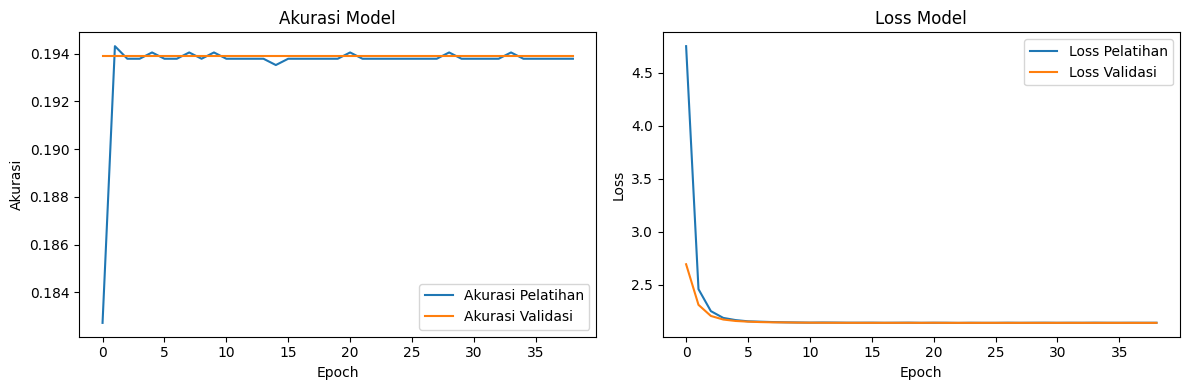

Plot pelatihan disimpan ke Google Drive.


In [12]:
# Sel 9: Plot kurva pelatihan
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RealWasteDataset/training_plot.png')
plt.show()
print("Plot pelatihan disimpan ke Google Drive.")

In [13]:
# Sel 10: Membaca dan menampilkan data dari history.pkl
import pickle
import pandas as pd

# Path ke file history.pkl
history_path = '/content/drive/MyDrive/RealWasteDataset/history.pkl'

# Baca file history.pkl
with open(history_path, 'rb') as f:
    history_dict = pickle.load(f)

# Dapatkan metrik dari history
epochs = range(1, len(history_dict['accuracy']) + 1)
data = {
    'Epoch': list(epochs),
    'Train Accuracy': history_dict['accuracy'],
    'Val Accuracy': history_dict['val_accuracy'],
    'Train Loss': history_dict['loss'],
    'Val Loss': history_dict['val_loss']
}

# Buat DataFrame untuk tampilan tabel
df = pd.DataFrame(data)

# Cetak tabel
print("Hasil Pelatihan per Epoch:")
print(df.to_string(index=False))

# Deskripsi tren
print("\nAnalisis Tren:")
print(f"- Akurasi Pelatihan Tertinggi: {max(history_dict['accuracy']):.4f}")
print(f"- Akurasi Validasi Tertinggi: {max(history_dict['val_accuracy']):.4f}")
print(f"- Loss Pelatihan Terendah: {min(history_dict['loss']):.4f}")
print(f"- Loss Validasi Terendah: {min(history_dict['val_loss']):.4f}")

# Deskripsi perubahan akurasi dan loss
if history_dict['accuracy'][-1] > history_dict['accuracy'][0]:
    print("- Akurasi pelatihan meningkat selama pelatihan.")
else:
    print("- Akurasi pelatihan tidak meningkat secara signifikan.")
if history_dict['val_accuracy'][-1] > history_dict['val_accuracy'][0]:
    print("- Akurasi validasi meningkat selama pelatihan.")
else:
    print("- Akurasi validasi tidak meningkat secara signifikan.")
if history_dict['loss'][-1] < history_dict['loss'][0]:
    print("- Loss pelatihan menurun selama pelatihan.")
else:
    print("- Loss pelatihan tidak menurun secara signifikan.")
if history_dict['val_loss'][-1] < history_dict['val_loss'][0]:
    print("- Loss validasi menurun selama pelatihan.")
else:
    print("- Loss validasi tidak menurun secara signifikan.")

Hasil Pelatihan per Epoch:
 Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss
     1        0.182728       0.19392    4.752627  2.694899
     2        0.194313       0.19392    2.459994  2.312084
     3        0.193786       0.19392    2.252638  2.207117
     4        0.193786       0.19392    2.188746  2.173401
     5        0.194049       0.19392    2.168014  2.159773
     6        0.193786       0.19392    2.156552  2.153370
     7        0.193786       0.19392    2.152970  2.149269
     8        0.194049       0.19392    2.149428  2.146910
     9        0.193786       0.19392    2.147028  2.145892
    10        0.194049       0.19392    2.145641  2.144241
    11        0.193786       0.19392    2.144143  2.143572
    12        0.193786       0.19392    2.145250  2.142944
    13        0.193786       0.19392    2.144629  2.142670
    14        0.193786       0.19392    2.143500  2.142433
    15        0.193523       0.19392    2.143461  2.142292
    16        0.193786       

In [14]:
# Sel 11: Analisis performa per kelas menggunakan precision, recall, dan F1-score
from sklearn.metrics import classification_report
import numpy as np

# Pastikan model, val_generator, dan classes sudah didefinisikan (dari sel sebelumnya)
# classes = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

# Reset generator untuk memastikan data dimuat dari awal
val_generator.reset()

# Dapatkan prediksi pada data validasi
print("Memprediksi pada data validasi...")
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Cetak laporan klasifikasi
print("\nLaporan Klasifikasi Per Kelas:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

Memprediksi pada data validasi...
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step

Laporan Klasifikasi Per Kelas:
                     precision    recall  f1-score   support

          Cardboard       0.00      0.00      0.00        93
      Food Organics       0.00      0.00      0.00        83
              Glass       0.00      0.00      0.00        84
              Metal       0.00      0.00      0.00       158
Miscellaneous Trash       0.00      0.00      0.00        99
              Paper       0.00      0.00      0.00       100
            Plastic       0.19      1.00      0.32       185
      Textile Trash       0.00      0.00      0.00        64
         Vegetation       0.00      0.00      0.00        88

           accuracy                           0.19       954
          macro avg       0.02      0.11      0.04       954
       weighted avg       0.04      0.19      0.06       954



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
